# Chapter 13

## Load packages / modules

Standard library:
- Printf for string formatting
- Statistics for mean and std functions
- Random for boostrap sampling

External:
- CSV.jl to load CSV files
- DataFrames.jl for tabular data
- CategoricalArrays.jl for working with categorical data columns
- GLM.jl for models
- CairoMakie.jl for plotting

In [1]:
using Printf, Statistics, Random
using CSV, DataFrames, CategoricalArrays, GLM, CairoMakie

## Load data

In [2]:
nhefs_all = DataFrame(CSV.File("nhefs.csv"));

In [3]:
size(nhefs_all)

(1629, 64)

In [4]:
for s in [:education, :exercise, :active]
    nhefs_all[!, s] = categorical(nhefs_all[!, s])
end

## Section 13.1

In the last chapter we initially restricted the data to include rows where none of the following columns were missing.

In [5]:
restriction_cols = [
    :sex, :age, :race, :wt82, :ht, :school, :alcoholpy, :smokeintensity
];

In fact, it turns out only one of those columns, `wt82`, has missing values.

In [6]:
println("       column    # missing")
for col in restriction_cols
    @printf "%15s     %2d\n" col sum(ismissing.(nhefs_all[!, col]))
end

       column    # missing
            sex      0
            age      0
           race      0
           wt82     63
             ht      0
         school      0
      alcoholpy      0
 smokeintensity      0


In other words, the only missing values (in those columns) are for censored rows.

In [7]:
nhefs_uncens = dropmissing(nhefs_all, :wt82);

In [8]:
size(nhefs_uncens)

(1566, 64)

## Section 13.2

In [9]:
combine(groupby(nhefs_uncens, :qsmk), nrow => :count)

,qsmk,count
,Int64,Int64
1,0,1163
2,1,403


### Program 13.1

Create the model to estimate $E[Y|A=a, C=0, L=l]$ for each combination of values of $A$ and $L$

In [10]:
spec = @formula(
    wt82_71 ~ qsmk
            + sex
            + race
            + education
            + exercise
            + active
            + age + age ^ 2
            + wt71 + wt71 ^ 2
            + smokeintensity + smokeintensity ^ 2
            + smokeyrs + smokeyrs ^ 2
            + qsmk & smokeintensity
);

In [11]:
ols = lm(spec, nhefs_uncens)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

wt82_71 ~ 1 + qsmk + sex + race + education + exercise + active + age + :(age ^ 2) + wt71 + :(wt71 ^ 2) + smokeintensity + :(smokeintensity ^ 2) + smokeyrs + :(smokeyrs ^ 2) + qsmk & smokeintensity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                              Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            -1.58817      4.31304      -0.37    0.7128  -10.0482       6.87186
qsmk                    2.55959      0.809149      3.16    0.0016    0.972449     4.14674
sex                    -1.43027      0.468958     -3.05    0.0023   -2.35013     -0.510411
race                    0.56011      0.581889      0.96 

Look at an example prediction, for the subject with ID 24770

In [12]:
example = nhefs_uncens[nhefs_uncens.seqn .== 24770, :]

,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,age,race
,Int64,Int64,Int64,Int64?,Int64?,Int64?,Int64?,Int64?,Int64,Int64,Int64
1,24770,0,0,missing,missing,missing,133,76,0,26,0


In [13]:
predict(ols, example)

1-element Vector{Union{Missing, Float64}}:
 0.3421568885357762

A quick look at mean and extremes of the **predicted** weight gain, across subjects

In [14]:
estimated_gain = predict(ols, nhefs_uncens);

In [15]:
println("   min     mean      max")
println("------------------------")
@printf "%6.2f   %6.2f   %6.2f" minimum(estimated_gain) mean(estimated_gain) maximum(estimated_gain)

   min     mean      max
------------------------
-10.88     2.64     9.88

A quick look at mean and extreme values for **actual** weight gain

In [16]:
min_val = minimum(nhefs_uncens.wt82_71)
mean_val = mean(nhefs_uncens.wt82_71)
max_val = maximum(nhefs_uncens.wt82_71)

println("   min     mean      max")
println("------------------------")
@printf "%6.2f   %6.2f   %6.2f" min_val mean_val max_val

   min     mean      max
------------------------
-41.28     2.64    48.54

A scatterplot of predicted vs actual

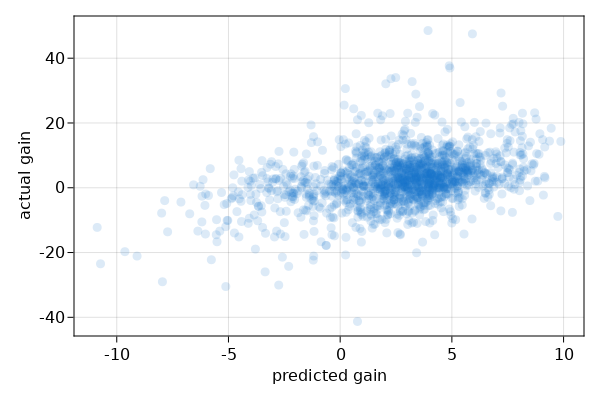

In [17]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(fig[1, 1], xlabel="predicted gain", ylabel="actual gain")

scatter!(ax, estimated_gain, nhefs_uncens.wt82_71, color=(:dodgerblue3, 0.15))

fig

## Section 13.3

### Program 13.2

The 4 steps to the method are
1. expansion of dataset
2. outcome modeling
3. prediction
4. standardization by averaging

I am going to use a few shortcuts. "Expansion of dataset" means creating the 3 blocks described in the text. The first block (the original data) is the only one that contributes to the model, so I'll just build the regression from the first block. The 2nd and 3rd blocks are only needed for predictions, so I'll only create them at prediction-time.

Thus my steps will look more like
1. outcome modeling, on the original data
2. prediction on expanded dataset
3. standardization by averaging

In [18]:
df = DataFrame(
    name = [
        "Rheia", "Kronos", "Demeter", "Hades", "Hestia", "Poseidon", 
        "Hera", "Zeus", "Artemis", "Apollo", "Leto", "Ares", "Athena", 
        "Hephaestus", "Aphrodite", "Cyclope", "Persephone", "Hermes", 
        "Hebe", "Dionysus"
    ],
    L = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    A = [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    Y = [0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
);

In [19]:
ols = lm(@formula(Y ~ A + L + A & L), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Y ~ 1 + A + L + A & L

Coefficients:
────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   0.25           0.255155   0.98    0.3418  -0.290905   0.790905
A            -1.73967e-16    0.360844  -0.00    1.0000  -0.764955   0.764955
L             0.416667       0.389756   1.07    0.3009  -0.409579   1.24291
A & L         1.60607e-16    0.495933   0.00    1.0000  -1.05133    1.05133
────────────────────────────────────────────────────────────────────────────

<br>
Next make predictions from the second block, with all A = 0.

"the average of all predicted values in the second block is precisely the standardized mean in the untreated"

In [20]:
df0 = DataFrame(A = zeros(nrow(df)), L = df.L)
A0_pred = predict(ols, df0)

@printf "standardized mean: %0.2f" mean(A0_pred)

standardized mean: 0.50

<br>
Finally, make predictions from the third block, with all A = 1.

"To estimate the standardized mean outcome in the treated, we compute the average of all predicted values in the third block."

In [21]:
df1 = DataFrame(A = ones(nrow(df)), L = df.L)
A1_pred = predict(ols, df1)

@printf "standardized mean: %0.2f" mean(A1_pred)

standardized mean: 0.50

### Program 13.3

We repeat the steps done above, but for the `nhefs_all` data, using both censored and uncensored rows:

1. outcome modeling, on the original data
2. prediction on expanded dataset
3. standardization by averaging

Step 1: Outcome modeling on the `nhefs_all` data

In [22]:
spec = @formula(
    wt82_71 ~ qsmk
            + sex
            + race
            + education
            + exercise
            + active
            + age + age ^ 2
            + wt71 + wt71 ^ 2
            + smokeintensity + smokeintensity ^ 2
            + smokeyrs + smokeyrs ^ 2
            + qsmk & smokeintensity
);

In [23]:
ols = lm(spec, nhefs_all)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

wt82_71 ~ 1 + qsmk + sex + race + education + exercise + active + age + :(age ^ 2) + wt71 + :(wt71 ^ 2) + smokeintensity + :(smokeintensity ^ 2) + smokeyrs + :(smokeyrs ^ 2) + qsmk & smokeintensity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                              Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            -1.58817      4.31304      -0.37    0.7128  -10.0482       6.87186
qsmk                    2.55959      0.809149      3.16    0.0016    0.972449     4.14674
sex                    -1.43027      0.468958     -3.05    0.0023   -2.35013     -0.510411
race                    0.56011      0.581889      0.96 

Step 2: Prediction on expanded dataset

In [24]:
block2_data = copy(nhefs_all)
block2_data[!, :qsmk] .= 0;

In [25]:
block2_pred = predict(ols, block2_data);

In [26]:
block3_data = copy(nhefs_all)
block3_data[!, :qsmk] .= 1;

In [27]:
block3_pred = predict(ols, block3_data);

Step 3: Standardization by averaging

In [28]:
orig_mean = mean(predict(ols, nhefs_all))
block2_mean = mean(block2_pred)
block3_mean = mean(block3_pred)
est_diff = block3_mean - block2_mean

@printf "original mean prediction: %0.2f\n\n" orig_mean

@printf " block 2 mean prediction: %0.2f\n" block2_mean
@printf " block 3 mean prediction: %0.2f\n\n" block3_mean

@printf "  causal effect estimate: %0.2f" est_diff

original mean prediction: 2.56

 block 2 mean prediction: 1.66
 block 3 mean prediction: 5.18

  causal effect estimate: 3.52

<br>
The model here in step 1 is the same as in Program 13.1, but the "block 1" mean prediction is different. Both models are fit on the uncensored rows (the second model doesn't use rows where `wt82_71` is missing), but the block means are over both censored and uncensored rows.

### Program 13.4

Use bootstrap to calculate the confidence interval on the previous estimate

In [29]:
num_samples = 2000

boot_samples = zeros(num_samples)

for i in 1:num_samples
    rand_indices = rand(1:nrow(nhefs_all), nrow(nhefs_all))
    sample_data = nhefs_all[rand_indices, :]
    
    block2_data = copy(sample_data)
    block2_data[!, :qsmk] .= 0
    
    block3_data = copy(sample_data)
    block3_data[!, :qsmk] .= 1
    
    ols = lm(spec, sample_data)
    
    block2_pred = predict(ols, block2_data)
    block3_pred = predict(ols, block3_data)
    
    boot_samples[i] = mean(block3_pred) - mean(block2_pred)
end

In [30]:
est_std = std(boot_samples);

In [31]:
lo = est_diff - 1.96 * est_std
hi = est_diff + 1.96 * est_std

println("               estimate   95% C.I.")
@printf  "causal effect   %6.1f   (%0.1f, %0.1f)" est_diff lo hi

               estimate   95% C.I.
causal effect      3.5   (2.6, 4.5)

This confidence interval can be slightly different from the book values, because of bootstrap randomness